In [1]:
# Custom Imports
from typing import Union
import sys
sys.path.append("..")
import data_utils
import GradCertModule
import XAIArchitectures
# Deep Learning Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
import pytorch_lightning as pl
# Standard Lib Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dataset = "CREDIT"

if(dataset == "GERMAN"):
    negative_cls = 0
    sensitive_features = [] 
    sens = ['status_sex_A91', 'status_sex_A92', 'status_sex_A93', 'status_sex_A94']
    drop_columns = []
    train_ds, test_ds = data_utils.get_german_data(sensitive_features, drop_columns=drop_columns)

elif(dataset == "CREDIT"):
    negative_cls = 1
    sensitive_features = [] 
    sens = ['x2_1.0', 'x2_2.0']
    drop_columns = []
    train_ds, test_ds = data_utils.get_credit_data(sensitive_features, drop_columns=drop_columns)
    
elif(dataset == "ADULT"):
    negative_cls = 1
    sensitive_features = [] 
    sens = ['sex_Female', 'sex_Male', 'race_Amer-Indian-Eskimo', 
            'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White',]
    drop_columns = ['native-country'] #, 'education']
    train_ds, test_ds = data_utils.get_adult_data(sensitive_features, drop_columns=drop_columns)
    
elif(dataset == "CRIME"):
    negative_cls = 1
    CRIME_DROP_COLUMNS = [
    'HispPerCap', 'LandArea', 'LemasPctOfficDrugUn', 'MalePctNevMarr',
    'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'MedRent',
    'MedYrHousBuilt', 'OwnOccHiQuart', 'OwnOccLowQuart',
    'OwnOccMedVal', 'PctBornSameState', 'PctEmplManu',
    'PctEmplProfServ', 'PctEmploy', 'PctForeignBorn', 'PctImmigRec5',
    'PctImmigRec8', 'PctImmigRecent', 'PctRecImmig10', 'PctRecImmig5',
    'PctRecImmig8', 'PctRecentImmig', 'PctSameCity85',
    'PctSameState85', 'PctSpeakEnglOnly', 'PctUsePubTrans',
    'PctVacMore6Mos', 'PctWorkMom', 'PctWorkMomYoungKids',
    'PersPerFam', 'PersPerOccupHous', 'PersPerOwnOccHous',
    'PersPerRentOccHous', 'RentHighQ', 'RentLowQ', 'Unnamed: 0',
    'agePct12t21', 'agePct65up', 'householdsize', 'indianPerCap',
    'pctUrban', 'pctWFarmSelf', 'pctWRetire', 'pctWSocSec', 'pctWWage',
    'whitePerCap'
    ]
    sensitive_features = []
    sens = ['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp']
    train_ds, test_ds = data_utils.get_crime_data(sensitive_features, drop_columns=CRIME_DROP_COLUMNS)

/Users/matthewwicker/Desktop/Development/CertifiedExplanations/TABULAR/data_utils.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[cf] = features[cf].astype(str).astype('category')


In [2]:
#print(train_ds.X_df.columns.tolist())
cols = train_ds.X_df.columns.tolist()
print(cols)
sens_inds = []
for i in sens:
    sens_inds.append(cols.index(i))
print(sens_inds)

if(dataset == "ADULT"):
    AGE = [cols.index('age')]
    RACE = [cols.index(i) for i in ['race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White']]
    GENDER = [cols.index(i) for i in ['sex_Female', 'sex_Male']]
    FINANCES = [cols.index(i) for i in ['capital-gain', 'capital-loss']]
    EDUCATION = [cols.index(i) for i in ['education_10th', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 
                                         'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters',
                                         'education_Preschool', 'education_Prof-school', 'education_Some-college']]     
    EMPLOYMENT = [cols.index(i) for i in ['hours-per-week', 'occupation_Adm-clerical', 'occupation_Armed-Forces', 'occupation_Craft-repair', 'occupation_Exec-managerial', 'occupation_Farming-fishing', 
                                          'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct', 'occupation_Other-service', 'occupation_Priv-house-serv', 'occupation_Prof-specialty', 
                                          'occupation_Protective-serv', 'occupation_Sales', 'occupation_Tech-support', 'occupation_Transport-moving', 'workclass_Local-gov', 'workclass_Private',
                                          'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay']]          
    PERSONAL = [cols.index(i) for i in ['hours-per-week', 'relationship_Husband', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'marital-status_Divorced',
                                        'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse', 'marital-status_Married-spouse-absent', 'marital-status_Never-married', 'marital-status_Separated', 'marital-status_Widowed']]
                           
elif(dataset == "CREDIT"):
    AMOUNT = [cols.index('x1')]
    AGE = [cols.index(i) for i in [ 'x5_21.0', 'x5_22.0', 'x5_23.0', 'x5_24.0', 'x5_25.0', 'x5_26.0', 'x5_27.0', 'x5_28.0', 'x5_29.0', 'x5_30.0', 'x5_31.0', 
                                   'x5_32.0', 'x5_33.0', 'x5_34.0', 'x5_35.0', 'x5_36.0', 'x5_37.0', 'x5_38.0', 'x5_39.0', 'x5_40.0', 'x5_41.0', 'x5_42.0', 
                                   'x5_43.0', 'x5_44.0', 'x5_45.0', 'x5_46.0', 'x5_47.0', 'x5_48.0', 'x5_49.0', 'x5_50.0', 'x5_51.0', 'x5_52.0', 'x5_53.0', 
                                   'x5_54.0', 'x5_55.0', 'x5_56.0', 'x5_57.0', 'x5_58.0', 'x5_59.0', 'x5_60.0', 'x5_61.0', 'x5_62.0', 'x5_63.0', 'x5_64.0', 
                                   'x5_65.0', 'x5_66.0', 'x5_67.0', 'x5_68.0', 'x5_69.0', 'x5_70.0', 'x5_71.0', 'x5_72.0', 'x5_73.0', 'x5_74.0', 'x5_75.0', 
                                   'x5_79.0']]
    GENDER = [cols.index(i) for i in ['x2_1.0', 'x2_2.0']]
    EDUCATION = [cols.index(i) for i in ['x2_1.0', 'x2_2.0']]
    PERSONAL = [cols.index(i) for i in ['x4_0.0', 'x4_1.0', 'x4_2.0', 'x4_3.0']]
    BILLS = [cols.index(i) for i in ['x12', 'x13', 'x14', 'x15', 'x16', 'x17']]
    PAYMENTS = [cols.index(i) for i in ['x6_-1.0', 'x6_-2.0', 'x6_0.0', 'x6_1.0', 'x6_2.0', 'x6_3.0', 'x6_4.0', 'x6_5.0', 'x6_6.0', 'x6_7.0', 'x6_8.0', 
                                        'x7_-1.0', 'x7_-2.0', 'x7_0.0', 'x7_1.0', 'x7_2.0', 'x7_3.0', 'x7_4.0', 'x7_5.0', 'x7_6.0', 'x7_7.0', 'x7_8.0', 
                                        'x8_-1.0', 'x8_-2.0', 'x8_0.0', 'x8_1.0', 'x8_2.0', 'x8_3.0', 'x8_4.0', 'x8_5.0', 'x8_6.0', 'x8_7.0', 'x8_8.0', 
                                        'x9_-1.0', 'x9_-2.0', 'x9_0.0', 'x9_1.0', 'x9_2.0', 'x9_3.0', 'x9_4.0', 'x9_5.0', 'x9_6.0', 'x9_7.0', 'x9_8.0', 
                                        'x10_-1.0', 'x10_-2.0', 'x10_0.0', 'x10_2.0', 'x10_3.0', 'x10_4.0', 'x10_5.0', 'x10_6.0', 'x10_7.0', 'x10_8.0', 
                                        'x11_-1.0', 'x11_-2.0', 'x11_0.0', 'x11_2.0', 'x11_3.0', 'x11_4.0', 'x11_5.0', 'x11_6.0', 'x11_7.0', 'x11_8.0',
                                        'x18', 'x19', 'x20', 'x21', 'x22', 'x23']]
                           

['x1', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x10_-1.0', 'x10_-2.0', 'x10_0.0', 'x10_2.0', 'x10_3.0', 'x10_4.0', 'x10_5.0', 'x10_6.0', 'x10_7.0', 'x10_8.0', 'x11_-1.0', 'x11_-2.0', 'x11_0.0', 'x11_2.0', 'x11_3.0', 'x11_4.0', 'x11_5.0', 'x11_6.0', 'x11_7.0', 'x11_8.0', 'x2_1.0', 'x2_2.0', 'x3_0.0', 'x3_1.0', 'x3_2.0', 'x3_3.0', 'x3_4.0', 'x3_5.0', 'x3_6.0', 'x4_0.0', 'x4_1.0', 'x4_2.0', 'x4_3.0', 'x5_21.0', 'x5_22.0', 'x5_23.0', 'x5_24.0', 'x5_25.0', 'x5_26.0', 'x5_27.0', 'x5_28.0', 'x5_29.0', 'x5_30.0', 'x5_31.0', 'x5_32.0', 'x5_33.0', 'x5_34.0', 'x5_35.0', 'x5_36.0', 'x5_37.0', 'x5_38.0', 'x5_39.0', 'x5_40.0', 'x5_41.0', 'x5_42.0', 'x5_43.0', 'x5_44.0', 'x5_45.0', 'x5_46.0', 'x5_47.0', 'x5_48.0', 'x5_49.0', 'x5_50.0', 'x5_51.0', 'x5_52.0', 'x5_53.0', 'x5_54.0', 'x5_55.0', 'x5_56.0', 'x5_57.0', 'x5_58.0', 'x5_59.0', 'x5_60.0', 'x5_61.0', 'x5_62.0', 'x5_63.0', 'x5_64.0', 'x5_65.0', 'x5_66.0', 'x5_67.0', 'x5_68.0', 'x5_69.0', 'x5_70.0', 'x5_7

In [3]:
X_train = train_ds.X_df.to_numpy()
y_train = torch.squeeze(torch.Tensor(train_ds.y_df.to_numpy()).to(torch.int64))

X_test = test_ds.X_df.to_numpy()
y_test = torch.squeeze(torch.Tensor(test_ds.y_df.to_numpy()).to(torch.int64))

In [4]:

class custDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).float()
        self.y = y
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return self.X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    

CustTrain = custDataset(X_train, y_train)    
CustTest = custDataset(X_test, y_test)

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, train, val, test, batch_size=32):
        super().__init__()
        self.train_data = train
        self.val_data = val
        self.test_data = test
        self.batch_size = batch_size
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size)
    
dm = CustomDataModule(CustTrain, CustTest, CustTest)

In [5]:
ALPHA = 0.0            # Regularization Parameter (Weights the Reg. Term)
EPSILON = 0.0          # Input Peturbation Budget at Training Time
GAMMA = 0.0            # Model Peturbation Budget at Training Time 
                       #(Changed to proportional budget rather than absolute)
    
POISON = 0.0
    
LEARN_RATE = 0.0005     # Learning Rate Hyperparameter
HIDDEN_DIM = 256       # Hidden Neurons Hyperparameter
HIDDEN_LAY = 2         # Hidden Layers Hyperparameter
MAX_EPOCHS = 25

EPSILON_LINEAR = True   # Put Epsilon on a Linear Schedule?
GAMMA_LINEAR = True     # Put Gamma on a Linear Schedule?

In [6]:

model = XAIArchitectures.FullyConnected(hidden_dim=HIDDEN_DIM, hidden_lay=HIDDEN_LAY, dataset=dataset)
model.set_params(alpha=ALPHA, epsilon=EPSILON, gamma=GAMMA, 
                learn_rate=LEARN_RATE, max_epochs=MAX_EPOCHS,
                epsilon_linear=EPSILON_LINEAR, gamma_linear=GAMMA_LINEAR)


In [7]:

SCHEDULED = EPSILON_LINEAR or GAMMA_LINEAR    
#MODEL_ID = "FCN_e=%s_g=%s_h=%s_l=%s_s=%s"%(EPSILON, GAMMA, HIDDEN_DIM, HIDDEN_LAY, SCHEDULED)  
MODEL_ID = "%s_FCN_e=%s_g=%s_a=%s_l=%s_h=%s_s=%s_p=%s"%(dataset, EPSILON, GAMMA, ALPHA, 
                                                        HIDDEN_LAY, HIDDEN_DIM, SCHEDULED, POISON)
ckpt = torch.load("Poisoned/%s.ckpt"%(MODEL_ID))
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
checkpoint = torch.load("Poisoned/%s.ckpt"%(MODEL_ID))
for key in checkpoint:
    print(key)
#model.load_state_dict(checkpoint['model_state_dict'])
model.load_state_dict(torch.load('Poisoned/%s.pt'%(MODEL_ID)))


epoch
global_step
pytorch-lightning_version
state_dict
loops
callbacks
optimizer_states
lr_schedulers
hparams_name
hyper_parameters


<All keys matched successfully>

In [8]:
# Measure Test Set Accuracy
correct = 0
for INDEX in range(len(X_test)):
    data = torch.Tensor([X_test[INDEX]])
    out, cls = model.classify(data)
    if(cls == y_test[INDEX]):
        correct += 1 
correct /= len(X_test)
print("Test set accuracy: ", correct)

/Users/matthewwicker/opt/anaconda3/envs/XAIenvironment/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  after removing the cwd from sys.path.


Test set accuracy:  0.8148333333333333


In [9]:
def gen_model_id(GAM_T=0.0, POIS=0.0):
    if(GAM_T == 0):
        ALPHA = 0.0            # Regularization Parameter (Weights the Reg. Term)
    else:
        ALPHA = 0.5
    EPSILON = 0.0          # Input Peturbation Budget at Training Time

    LEARN_RATE = 0.0005     # Learning Rate Hyperparameter
    HIDDEN_DIM = 256       # Hidden Neurons Hyperparameter
    HIDDEN_LAY = 2         # Hidden Layers Hyperparameter
    MAX_EPOCHS = 25

    EPSILON_LINEAR = True   # Put Epsilon on a Linear Schedule?
    GAMMA_LINEAR = True     # Put Gamma on a Linear Schedule?
    
    MODEL_ID = "%s_FCN_e=%s_g=%s_a=%s_l=%s_h=%s_s=%s_p=%s"%(dataset, EPSILON, GAM_T, ALPHA, HIDDEN_LAY, HIDDEN_DIM, SCHEDULED, POIS)     
    return MODEL_ID

In [10]:


# Measuring Fairness of Explanations: 

# We know that models reflect biases in their data, and we would like models whose explanations flag this
# bias where possible. In order to measure this, we train models on datasets with controlled bias introduced
# and measure how well explanations flag the model bias. 



M_ID = gen_model_id(0.0, 0.0)


def fairness_computation(model, X_test, y_test, sens_inds):
    X_maj = []
    y_maj = []
    X_min = []
    y_min = []

    for i in range(len(X_test)):
        if(X_test[i][sens_inds[0]] == 0.0):
            X_maj.append(X_test[i])
            y_maj.append(y_test[i])
        elif(X_test[i][sens_inds[0]] == 1.0):
            X_min.append(X_test[i])
            y_min.append(y_test[i])

    X_maj = np.asarray(X_maj)
    y_maj = np.asarray(y_maj)
    X_min = np.asarray(X_min)
    y_min = np.asarray(y_min)


    y_pred_min = []
    y_pred_maj = []

    maj_tp = 0
    maj_tn = 0
    maj_fp = 0
    maj_fn = 0

    min_tp = 0
    min_tn = 0
    min_fp = 0
    min_fn = 0

    acc = 0
    majority = 0
    minority = 0
    min_pos, min_neg = 0, 0
    maj_pos, maj_neg = 0, 0

    for i in range(len(X_test)):
        y_pred = model(torch.Tensor([X_test[i]]))
        corr = int(torch.argmax(y_pred) == y_test[i])
        acc += corr

        #cls = (int(torch.argmax(y_pred).detach().numpy()))
        # Majority Group Data
        if(X_test[i][sens_inds[0]] == 0.0):
            majority += 1
            if(corr == 1 and torch.argmax(y_pred) == 1):
                maj_tp += 1
            elif(corr == 1 and torch.argmax(y_pred) == 0):
                maj_tn += 1
            elif(corr == 0 and torch.argmax(y_pred) == 1):
                maj_fp += 1
            elif(corr == 0 and torch.argmax(y_pred) == 0):
                maj_fn += 1
            # Sanity check:
            if(y_test[i] == 1):
                maj_pos += 1
            else:
                maj_neg += 1
        # Minority Group Data
        elif(X_test[i][sens_inds[0]] == 1.0):
            minority += 1
            if(corr == 1 and torch.argmax(y_pred) == 1):
                min_tp += 1
            elif(corr == 1 and torch.argmax(y_pred) == 0):
                min_tn += 1
            elif(corr == 0 and torch.argmax(y_pred) == 1):
                min_fp += 1
            elif(corr == 0 and torch.argmax(y_pred) == 0):
                min_fn += 1
            # Sanity check:
            if(y_test[i] == 1):
                min_pos += 1
            else:
                min_neg += 1

    #print("Neural Net Acc: \t", acc/len(X_test))

    p_rate_maj = (maj_tp + maj_fp)/(maj_pos+maj_neg)
    p_rate_min = (min_tp + min_fp)/(min_pos+min_neg)
    demographic_parity = abs(p_rate_maj - p_rate_min)
    #print("Demographic Parity: \t", demographic_parity)

    maj_tp_r = maj_tp/maj_pos
    min_tp_r = min_tp/min_pos
    equalized_opp = abs(maj_tp_r - min_tp_r)
    #print("Equalized Opp Disc: \t", equalized_opp)

    maj_tp_r = (maj_tp+maj_tn)/(maj_pos+maj_neg)
    min_tp_r = (min_tp+min_tn)/(min_pos+min_neg)
    equalized_acc = abs(maj_tp_r - min_tp_r)
    #print("Equalized Acc Disc: \t", equalized_acc)
    
    """
    maj_tp /= (maj_pos) # Total positives maj
    maj_tn /= (maj_neg) # Total negatives maj
    maj_fp /= (maj_neg)
    maj_fn /= (maj_pos)

    min_tp /= (min_pos) # Total positives min
    min_tn /= (min_neg) # Total negatives min
    min_fp /= (min_neg)
    min_fn /= (min_pos)


    print(" ")
    print("Majority Stats/Minority Stats:")
    print("TP:", round(maj_tp,3), "/", round(min_tp,3))
    print("TN:", round(maj_tn,3), "/", round(min_tn,3))
    print("FP:", round(maj_fp,3), "/", round(min_fp,3))
    print("FN:", round(maj_fn,3), "/", round(min_fn,3))
    """
    
    return demographic_parity, equalized_opp, equalized_acc, acc/len(X_test)


fairness_computation(model, X_test, y_test, sens_inds)



(0.015081939003354167,
 0.005219597799279052,
 0.025318590002456287,
 0.8148333333333333)

In [11]:
p_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dp_vals = []
for poison_rate in p_rate:
    M_ID = gen_model_id(0.0, poison_rate)
    model.load_state_dict(torch.load('Poisoned/%s.pt'%(M_ID)))
    dp, eo, ea, acc = fairness_computation(model, X_test[0:1000], y_test[0:1000], sens_inds)
    dp_vals.append(ea)
    #print(poison_rate, dp, eo, ea)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['#d7dfc0', '#9bc799', '#65a88e', '#477d89', '#3b4a71', '#2c1e3e']


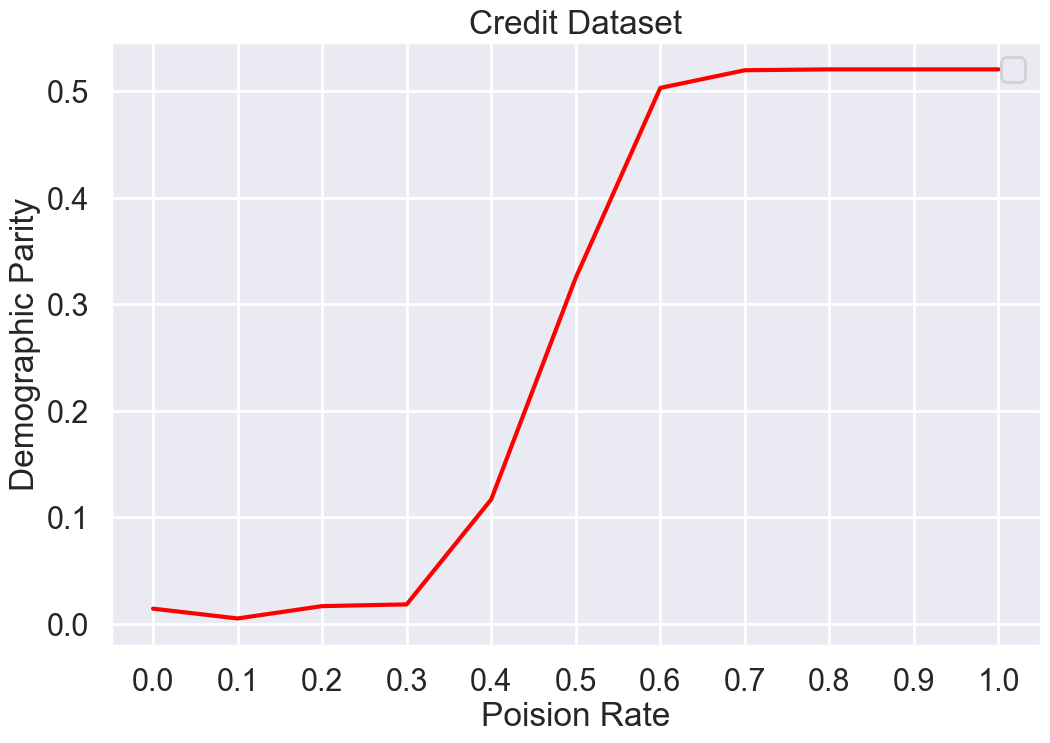

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(12, 8), dpi=100)


pal = sns.cubehelix_palette(start=.5, rot=-.75)
print(pal.as_hex())

plt.plot(dp_vals, color='r')
plt.legend()
ax = plt.gca()
ax.set_xticks(range(11))
ax.set_xticklabels(p_rate)


plt.title("Credit Dataset")
plt.ylabel("Demographic Parity")
plt.xlabel(r"Poision Rate")
plt.show()

In [13]:
from tqdm import trange
def detect_bias(model, inputs, labels):
    sens_exp = 0.0
    # Numerical issue handling is why there are small values
    for i in trange(len(inputs)):
        exp = GradCertModule.InputGrad(model, torch.Tensor([inputs[i]]), labels[i], nclasses=2)
        exp = np.abs(exp.detach().numpy())
        sens_exp += (sum(exp[sens_inds]) / (sum(exp) + 0.00000000001))
    sens_exp += 0.00000000001 
    sens_exp/=len(inputs)
    return sens_exp
 

In [14]:
p_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
dp_vals_clean = []
detec_vals_clean = []
for poison_rate in p_rate:
    M_ID = gen_model_id(0.0, poison_rate)
    model.load_state_dict(torch.load('Poisoned/%s.pt'%(M_ID)))
    dp, eo, ea, acc = fairness_computation(model, X_test, y_test, sens_inds)
    print(dp)
    dp_vals_clean.append(ea)
    detected = detect_bias(model, X_test[0:1000], y_test[0:1000])
    detec_vals_clean.append(detected)

0.015081939003354167


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 710.37it/s]


0.0593660534251461


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 713.77it/s]


0.13380502555519935


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 701.13it/s]


0.23144420529089071


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 729.54it/s]


0.4334579522257239


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 727.49it/s]


0.6931121001058845


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 726.03it/s]


0.9628613496864405


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 719.55it/s]


0.9961115575002394


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 718.69it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['#d7dfc0', '#9bc799', '#65a88e', '#477d89', '#3b4a71', '#2c1e3e']


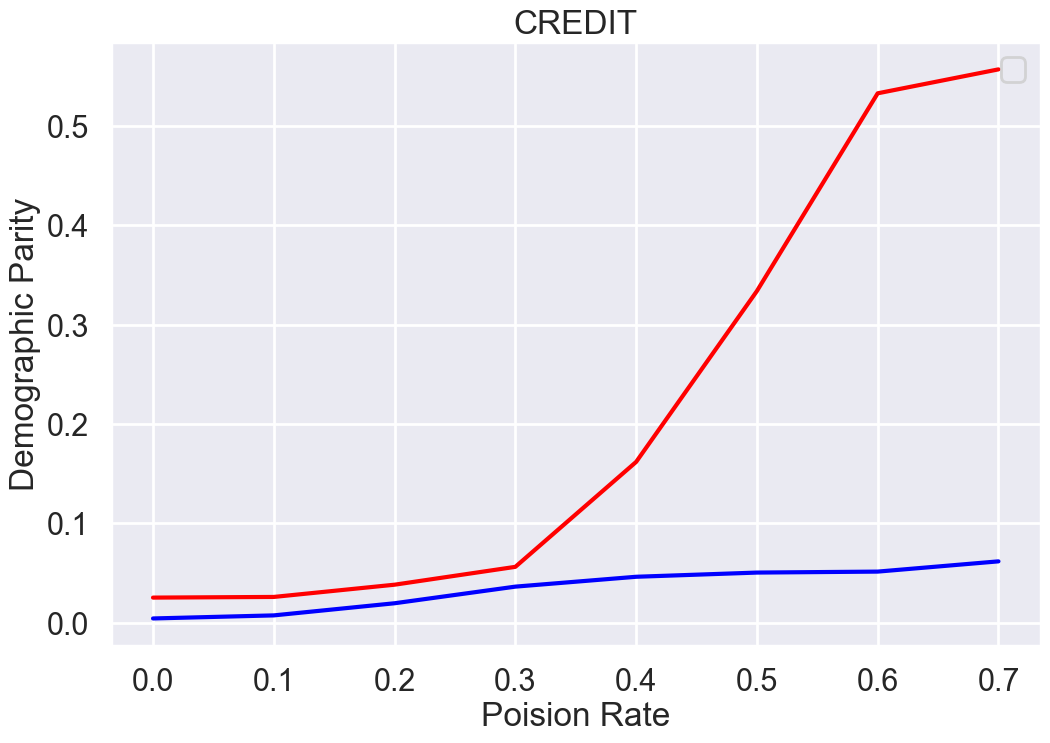

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(12, 8), dpi=100)


pal = sns.cubehelix_palette(start=.5, rot=-.75)
print(pal.as_hex())

plt.plot(dp_vals_clean, color='r')
plt.plot(detec_vals_clean, color='b')
plt.legend()
ax = plt.gca()
ax.set_xticks(range(len(p_rate)))
ax.set_xticklabels(p_rate)


plt.title("%s"%(dataset))
plt.ylabel("Demographic Parity")
plt.xlabel(r"Poision Rate")
plt.show()

['#d7dfc0', '#9bc799', '#65a88e', '#477d89', '#3b4a71', '#2c1e3e']


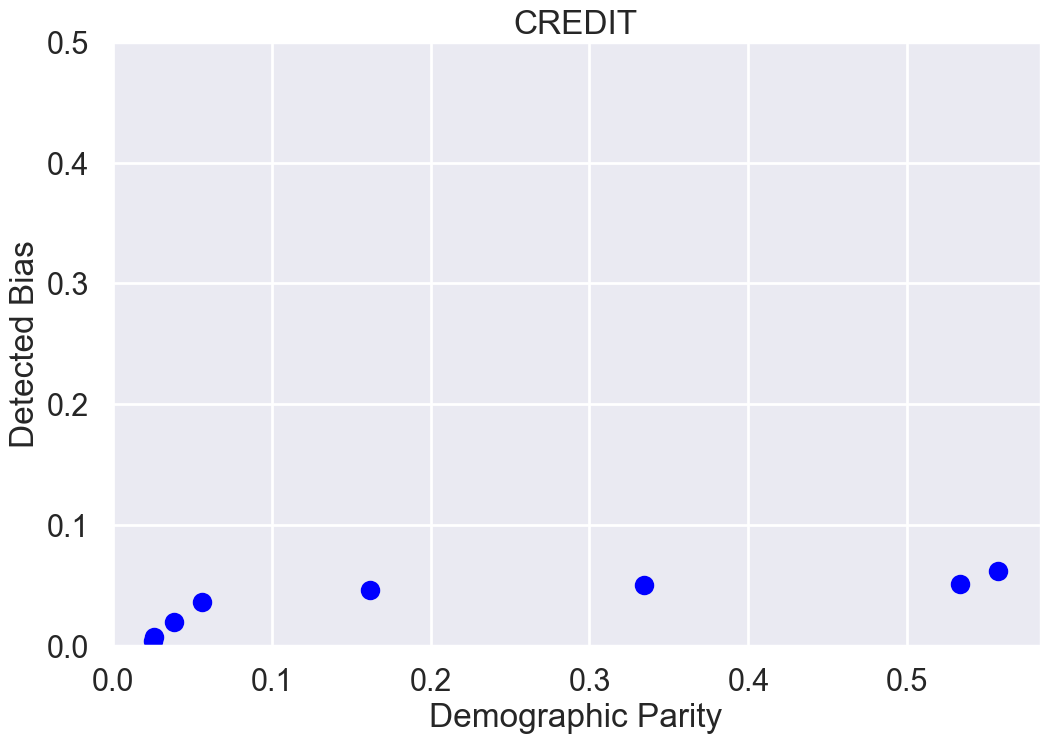

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(12, 8), dpi=100)


pal = sns.cubehelix_palette(start=.5, rot=-.75)
print(pal.as_hex())

plt.scatter(x=dp_vals_clean, y=detec_vals_clean, color='b')

plt.ylim([0, 0.5])

ax = plt.gca()


plt.title("%s"%(dataset))
plt.xlabel("Demographic Parity")
plt.ylabel(r"Detected Bias")
plt.show()

In [17]:
p_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
dp_vals_robust = []
detec_vals_robust = []
for poison_rate in p_rate:
    M_ID = gen_model_id(0.25, poison_rate)
    model.load_state_dict(torch.load('Poisoned/%s.pt'%(M_ID)))
    dp, eo, ea, acc = fairness_computation(model, X_test, y_test, sens_inds)
    print(dp, acc)
    dp_vals_robust.append(dp)
    detected = detect_bias(model, X_test[0:1000], y_test[0:1000])
    detec_vals_robust.append(detected)
    
    

0.0 0.7811666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 727.58it/s]


0.0 0.7811666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 729.78it/s]


0.0 0.7811666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 698.39it/s]


0.0 0.7811666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 671.02it/s]


0.0 0.7811666666666667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 713.90it/s]


1.0 0.5668333333333333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 725.17it/s]


1.0 0.5668333333333333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 731.17it/s]


1.0 0.5668333333333333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 710.61it/s]


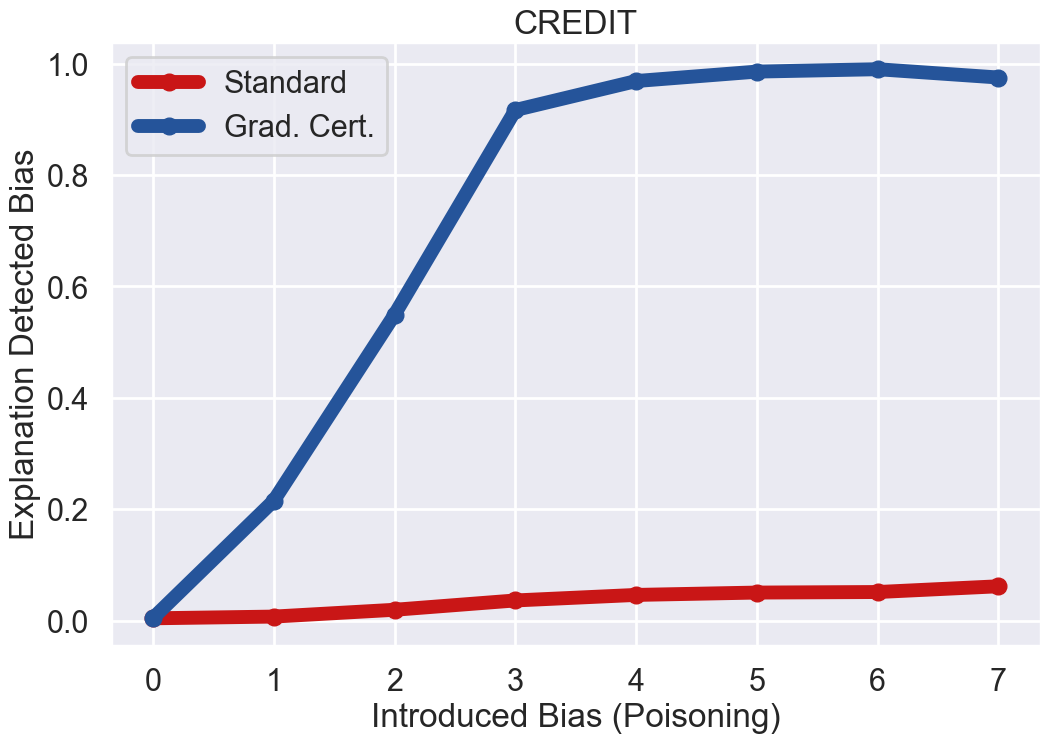

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(12, 8), dpi=100)

pal = sns.cubehelix_palette(start=.5, rot=-.75)

#plt.scatter(x=p_rate, y=detec_vals_clean, color='#c91616', label="Standard")
#plt.scatter(x=p_rate, y=detec_vals_robust, color='#25549a', label="Grad. Cert.")
plt.plot(detec_vals_clean, 'o-', color='#c91616', label="Standard", linewidth=10)
plt.plot(detec_vals_robust, 'o-', color='#25549a', label="Grad. Cert.", linewidth=10)
ax = plt.gca()
plt.legend()
plt.title("%s"%(dataset))
plt.xlabel("Introduced Bias (Poisoning)")
plt.ylabel(r"Explanation Detected Bias")
plt.show()